In [1]:
import sys
sys.path.append('..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
import seaborn as sns
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from scipy.stats import norm

In [2]:
def var_analysis(df_list, conf_level, usd_balance, positions, occurance_data=1000):

    usd_in_position = 0
    returns = pd.DataFrame()
    for pair in list(positions.keys()):
        usd_in_position += positions[pair]["long"] + positions[pair]["short"]
        temp_df = df_list[pair].copy()

        returns["long_"+pair] = temp_df["close"].pct_change()
        returns["short_"+pair] = -temp_df["close"].pct_change()
        
    if usd_in_position == 0:
        return [0] * 150
    
    weights = []   
    for pair in list(positions.keys()):
        weights.append(positions[pair]["long"] / usd_in_position)
        weights.append(positions[pair]["short"] / usd_in_position)

    weights = np.array(weights)

    # Generate Var-Cov matrix
    cov_matrix = returns.cov()

    # Calculate mean returns for each stock
    avg_rets = returns.mean()

    # Calculate mean returns for portfolio overall, 
    # using dot product to 
    # normalize individual means against investment weights
    port_mean = avg_rets.dot(weights)

    # Calculate portfolio standard deviation
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

    # Calculate mean of investment
    mean_investment = (1+port_mean) * usd_in_position

    # Calculate standard deviation of investmnet
    stdev_investment = usd_in_position * port_stdev

    # Using SciPy ppf method to generate values for the
    # inverse cumulative distribution function to a normal distribution
    # Plugging in the mean, standard deviation of our portfolio
    # as calculated above
    cutoff1 = norm.ppf(conf_level, mean_investment, stdev_investment)

    #Finally, we can calculate the VaR at our confidence interval
    var_1d1 = usd_in_position - cutoff1
    
    print(f"USD Balance: {usd_balance}$")
    print(f"USD in Position: {usd_in_position}$")
    print(f"Value at Risk 1 period: {round(var_1d1, 2)}$ ~ {round(var_1d1 / usd_balance * 100, 2)}%")

    # Calculate n Period VaR
    var_array = []
    num_periods = int(150)
    for x in range(1, num_periods+1):    
        var_array.append(np.round(var_1d1 * np.sqrt(x),2))

    print(f"Value at Risk 24 periods: {round(var_array[24], 2)}$ ~ {round(var_array[24] / usd_balance * 100, 2)}%")
    print(f"Value at Risk 100 periods: {round(var_array[100], 2)}$ ~ {round(var_array[100] / usd_balance * 100, 2)}%")


    # Build plot
    plt.xlabel("Period #")
    plt.ylabel("Max portfolio loss (USD)")
    plt.title(f"Max portfolio loss (VaR) over {num_periods} periods")
    plt.plot(var_array, "r")
    plt.show()
    
    return cov_matrix

USD Balance: 1000$
USD in Position: 1000$
Value at Risk 1 period: 16.35$ ~ 1.64%
Value at Risk 24 periods: 81.76$ ~ 8.18%
Value at Risk 100 periods: 164.33$ ~ 16.43%


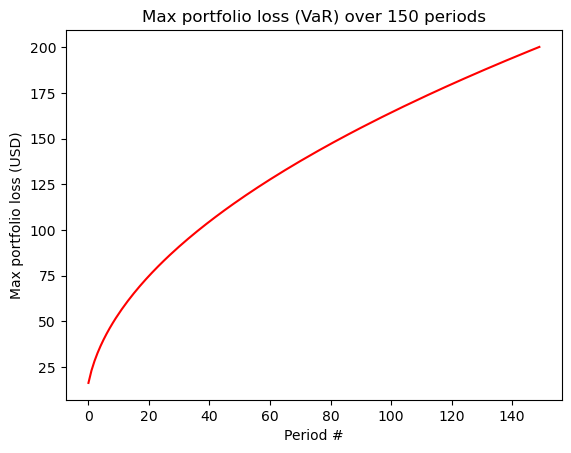

In [3]:
exchange_name = "binance"
tf = "1h"
usd_balance = 1000

occurance_data = 10000
conf_level = 0.05

positions = {
    "BTC/USDT":{"long":0,"short":0},
    "ETH/USDT":{"long":0,"short":0},
    "BNB/USDT":{"long":0,"short":0},
    "XRP/USDT":{"long":0,"short":0},
    "SOL/USDT":{"long":0,"short":0},
}


df_list = {}
exchange = ExchangeDataManager(exchange_name="binance", path_download="../database/exchanges")
for pair in positions.keys():
    df = exchange.load_data(coin=pair, interval="1h")       
    df_list[pair] = df.loc["2020":]

var0 = var_analysis(
    df_list=df_list,
    conf_level=conf_level,
    usd_balance=usd_balance,
    positions=positions,
    occurance_data=occurance_data
)

new_position = {"pair":"ETH/USDT", "long": 1000, "short": 0}
positions[new_position["pair"]]["long"] += new_position["long"]
positions[new_position["pair"]]["short"] += new_position["short"]

# position_to_analyse = "BTC/USDT"
# positions[position_to_analyse]["long"] = 0
# positions[position_to_analyse]["short"] = 0

var1 = var_analysis(
    df_list=df_list,
    conf_level=conf_level,
    usd_balance=usd_balance,
    positions = positions,
    occurance_data=occurance_data,
)

In [4]:
var1

,long_BTC/USDT,short_BTC/USDT,long_ETH/USDT,short_ETH/USDT,long_BNB/USDT,short_BNB/USDT,long_XRP/USDT,short_XRP/USDT,long_SOL/USDT,short_SOL/USDT
long_BTC/USDT,0.000063,-0.000063,0.000068,-0.000068,0.000061,-0.000061,0.000062,-0.000062,0.000074,-0.000074
short_BTC/USDT,-0.000063,0.000063,-0.000068,0.000068,-0.000061,0.000061,-0.000062,0.000062,-0.000074,0.000074
long_ETH/USDT,0.000068,-0.000068,0.000101,-0.000101,0.000080,-0.000080,0.000082,-0.000082,0.000105,-0.000105
short_ETH/USDT,-0.000068,0.000068,-0.000101,0.000101,-0.000080,0.000080,-0.000082,0.000082,-0.000105,0.000105
long_BNB/USDT,0.000061,-0.000061,0.000080,-0.000080,0.000116,-0.000116,0.000080,-0.000080,0.000099,-0.000099
short_BNB/USDT,-0.000061,0.000061,-0.000080,0.000080,-0.000116,0.000116,-0.000080,0.000080,-0.000099,0.000099
long_XRP/USDT,0.000062,-0.000062,0.000082,-0.000082,0.000080,-0.000080,0.000160,-0.000160,0.000104,-0.000104
short_XRP/USDT,-0.000062,0.000062,-0.000082,0.000082,-0.000080,0.000080,-0.000160,0.000160,-0.000104,0.000104
long_SOL/USDT,0.000074,-0.000074,0.000105,-0.000105,0.000099,-0.000099,0.000104,-0.000104,0.000274,-0.000274
short_SOL/USDT,-0.000074,0.000074,-0.000105,0.000105,-0.000099,0.000099,-0.000104,0.000104,-0.000274,0.000274
